# Experiment 1

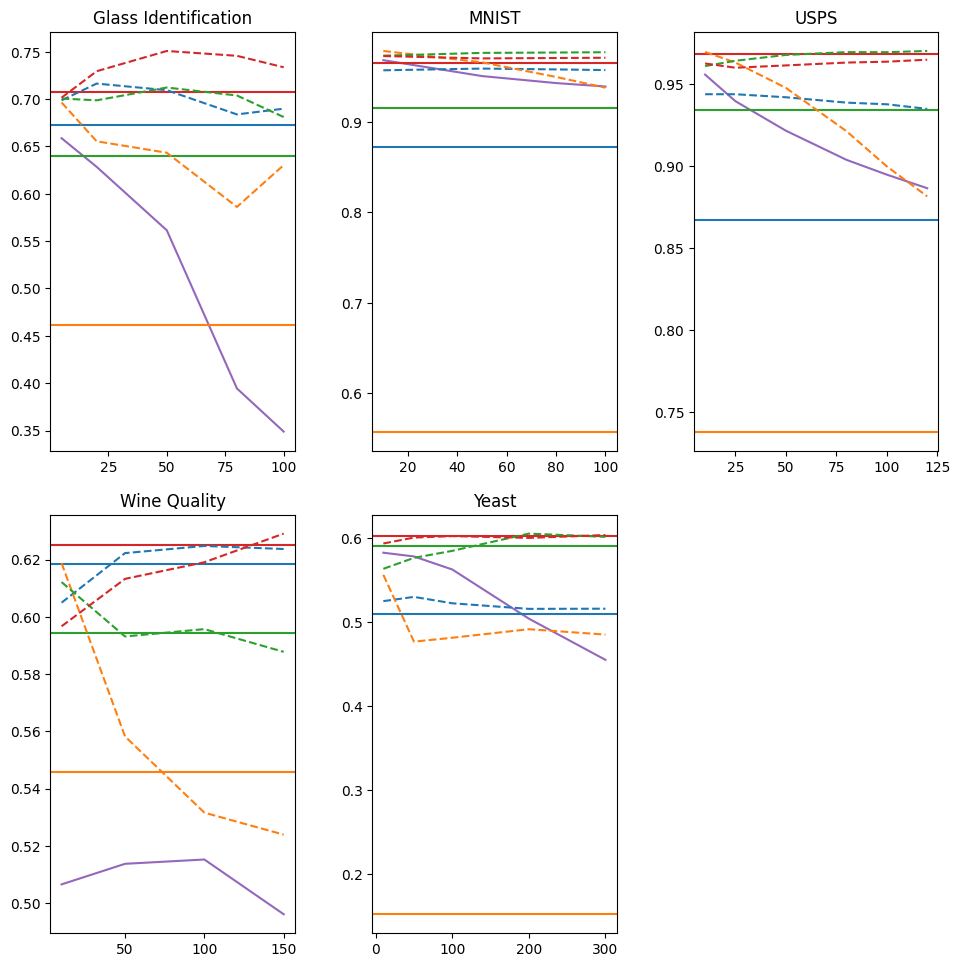

In [1]:
from average_results import ret_avg_results
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from math import ceil

ret = ret_avg_results()
datasets = ret.keys()

row_amount = 2
col_amount = ceil(len(datasets)/2)
fig, axs = plt.subplots(row_amount, col_amount,figsize=(10, 10))
fig.tight_layout(pad=2.5)
axs[1][2].set_visible(False)

type = 'acc'

clfs= ret[list(datasets)[0]]["clfs"]

ax = plt.gca()
colors = [next(ax._get_lines.prop_cycler)['color'] for _ in clfs + ['KNN']]

clfs_map = {
    'DecisionTree':'Decision Tree',
    'GaussianNB': 'Gaussian Naive Bayes',
    'LogisticRegression': 'Logistic Regression',
    'SVC': 'SVM',
    'KNN': 'KNN'
}

patches_clf = [mlines.Line2D(xdata=[0], ydata=[0], color=colors[i%len(clfs+['KNN'])], linestyle='solid', label=clfs_map[clf]) for i,clf in enumerate(clfs+ ['KNN'])]
patches_smart = [mlines.Line2D(xdata=[0], ydata=[0], color='black', linestyle='dashed', label='KNN+X')]

handles = patches_clf + patches_smart

dataset_map = {
    'wine': 'Wine Quality',
    'mnist': 'MNIST',
    'usps': 'USPS',
    'glass': 'Glass Identification',
    'yeast': 'Yeast'
}

for i, dataset in enumerate(sorted(datasets)):
    results_dict = ret[dataset]

    baseline_knn= results_dict[f"baseline_knn_{type}"]
    baseline= results_dict[f"baseline_{type}"]
    smart= results_dict[f"smart_{type}"]

    smart = np.swapaxes(smart, 1, 2)

    clfs= results_dict["clfs"]
    ks= results_dict['ks']
    thresholds= results_dict['thresholds']

    #print(i%len(datasets))
    #print(len(datasets))
    curr_ax = axs[i//col_amount, i%col_amount]

    curr_ax.set_title(f"{dataset_map[dataset]}")
    curr_ax.plot(ks, baseline_knn, label="KNN", linestyle='solid', color=colors[-1])

    for (iclf, clf) in enumerate(clfs):
        curr_ax.axhline(y=baseline[iclf], label=f'{clf}', color=colors[iclf%len(clfs)], linestyle='solid')

    for (iclf, clf), (it, threshold) in product(enumerate(clfs), enumerate(thresholds)):
        if threshold != 1.0:
            continue

        curr = smart[iclf, it]
        curr_ax.plot(ks, curr, color=colors[iclf%len(clfs)], linestyle='dashed')

#fig.legend(handles=handles, loc='lower right')
plt.show()
    # ax = axs[i]

    # ax.set_title(dataset)
    # ax.set_xlabel('Number of features')
    # ax.set_ylabel('Accuracy')
    # ax.legend()

# Experiment 2

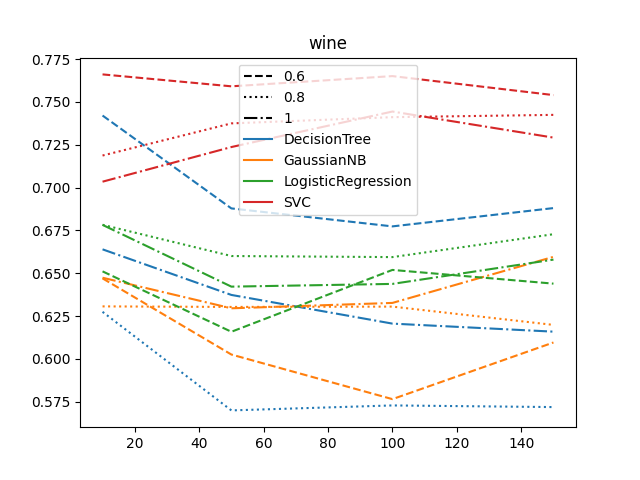

In [6]:
from average_results import ret_avg_results
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

%matplotlib widget

ret = ret_avg_results()
results = ret['wine']

def plot_results(results_dict, type='acc'):
    baseline_knn= results_dict[f"baseline_knn_{type}"]
    baseline= results_dict[f"baseline_{type}"]
    smart= results_dict[f"smart_{type}"]

    smart = np.swapaxes(smart, 1, 2)

    #print(smart_acc.shape)

    clfs= results_dict["clfs"]
    ks= results_dict['ks']
    thresholds= results_dict['thresholds']

    ax = plt.gca()
    colors = [next(ax._get_lines.prop_cycler)['color'] for _ in clfs]
    line_styles = ['dashed', 'dotted', 'dashdot']
    #patches = [mpatches.Patch(color='black', linestyle=line_styles[i%len(thresholds)], linewidth=3, label=threshold) for i,threshold in enumerate(thresholds)]
    patches_t = [mlines.Line2D(xdata=[0], ydata=[0], color='black', linestyle=line_styles[i%len(thresholds)], label=threshold) for i,threshold in enumerate(thresholds)]
    patches_clf = [mlines.Line2D(xdata=[0], ydata=[0], color=colors[i%len(clfs)], linestyle='solid', label=clf) for i,clf in enumerate(clfs)]

    patches = patches_t
    if type == 'time':
        patches += patches_clf

    plt.title(f"{results_dict['dataset']}")

    if type == 'acc':
        plt.plot(ks, baseline_knn, label="KNN", linestyle='solid')

        for (iclf, clf) in enumerate(clfs):
            plt.axhline(y=baseline[iclf], label=f'{clf}', color=colors[iclf%len(clfs)], linestyle='solid')

    

    for (iclf, clf), (it, threshold) in product(enumerate(clfs), enumerate(thresholds)):
        curr = smart[iclf, it]
        plt.plot(ks, curr, color=colors[iclf%len(clfs)], linestyle=line_styles[it%len(thresholds)])

    handles, _ = ax.get_legend_handles_labels()
    #print(handles[0].get_linewidth())

    plt.legend(handles=handles+patches)
    plt.show()


plot_results(results, type='time')

In [2]:
results.keys()

dict_keys(['dataset', 'baseline_knn_acc', 'baseline_acc', 'smart_acc', 'baseline_knn_time', 'baseline_time', 'smart_time', 'clfs', 'ks', 'thresholds'])

# OLD

In [1]:
import json


def parse_results(filename):
    baseline_dict = {}
    smart_decision_dict = {}

    with open(filename, 'r') as file:
        lines = file.readlines()

    current_baseline = None
    for line in lines:
        line = line.strip()

        if line.startswith('dataset:'):
            continue
        elif line.startswith('Baselines:'):
            current_dict = baseline_dict
        elif line.startswith('Smart Decision:'):
            current_dict = smart_decision_dict
            
        elif line.startswith('(') and ':' in line:
            current_baseline = line[line.index('(') + 1:line.index(')')]
            if len(line.split(': ')) == 1:
                current_dict[current_baseline] = {}

            else:
                current_dict[current_baseline] = float(line.split(': ')[1])
                
        elif line.startswith('k:'):
            k, accuracy = line.split('\t')
            k = int(k.split(':')[1])
            accuracy = float(accuracy)
            current_dict.setdefault(current_baseline, {})[k] = accuracy
        elif line.startswith(current_baseline):
            accuracy = float(line.split(': ')[1])
            current_dict[current_baseline]['accuracy'] = accuracy

    return baseline_dict, smart_decision_dict

def parse_json(filename, type='acc'):
    with open(filename, 'r') as file:
        x = json.load(file)
        baseline_dict, smart_decision_dict,ks = x[f'baseline_{type}'], x[f'smart_{type}'], x['ks']
    return baseline_dict, {f'KNN+{clf}':{k: smart_decision_dict[clf][ik] for ik,k in enumerate(ks)} for clf in smart_decision_dict.keys()}

In [2]:
import matplotlib.pyplot as plt

def plot_scores(baseline_dict, smart_decision_dict, normalize=False, type='acc'):
    knn_vals = baseline_dict['KNN']
    baseline_dict.pop('KNN')
    
    for baseline_model, baseline_accuracy in baseline_dict.items():
        smart_decision_model = 'KNN+' + baseline_model
        smart_decision_k_values = list(smart_decision_dict[smart_decision_model].keys())
        smart_decision_accuracy_values = list(smart_decision_dict[smart_decision_model].values())
        if normalize:
            plt.ylim([0,1])
            
        plt.axhline(y=baseline_accuracy, color='red', label='Baseline', linestyle='dashed')
        plt.plot(smart_decision_k_values, knn_vals, label='KNN')

        plt.plot(smart_decision_k_values, smart_decision_accuracy_values, 'bo', label='Smart Decision')
        plt.plot(smart_decision_k_values, smart_decision_accuracy_values, 'g--')

        plt.xlabel('k')
        if type=='acc':
            plt.ylabel('Accuracy')
        else:
            plt.ylabel('Duration')
        plt.title(f'{baseline_model}')
        plt.legend()
        plt.show()


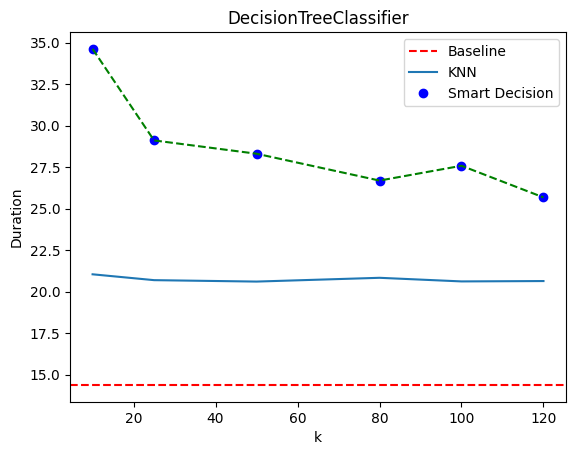

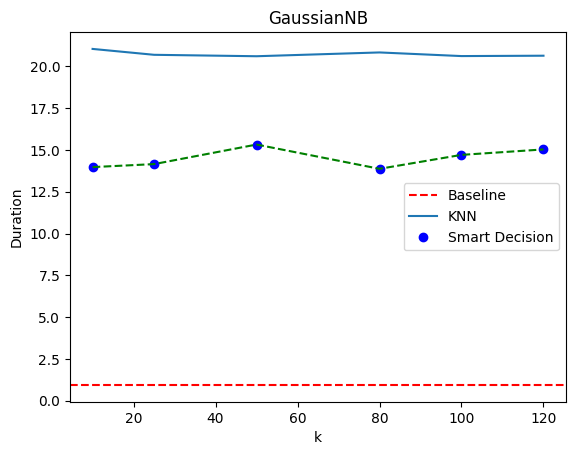

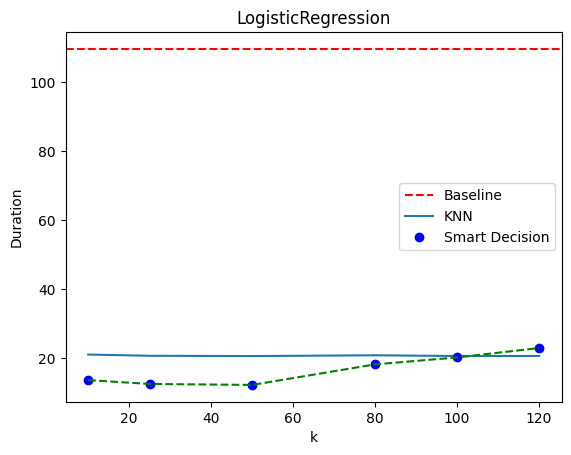

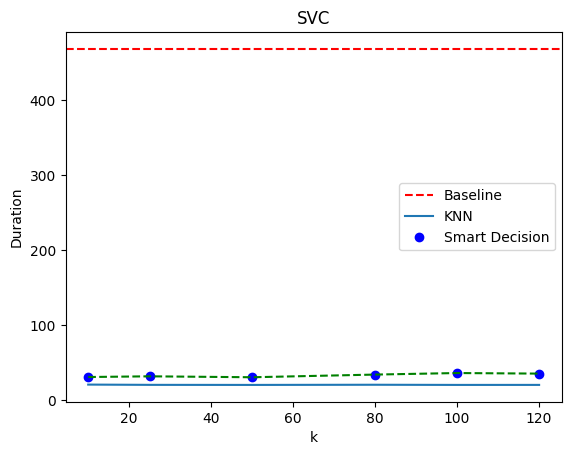

In [5]:
dataset='mnist'
import os
#type='acc'
type='time'
results_file_avg = os.path.join('results',dataset,'results_avg.json')
baseline_dict, smart_decision_dict = parse_json(results_file_avg, type=type)

# print("Baseline Dictionary:")
# print(baseline_dict)
# print("\nSmart Decision Dictionary:")
# print(smart_decision_dict)
# print()
plot_scores(baseline_dict, smart_decision_dict, normalize=False, type=type)

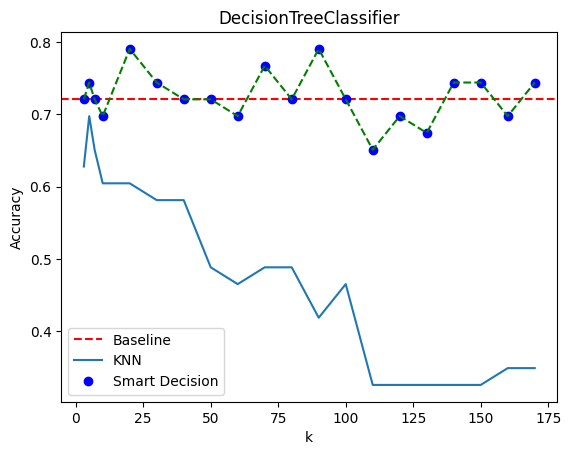

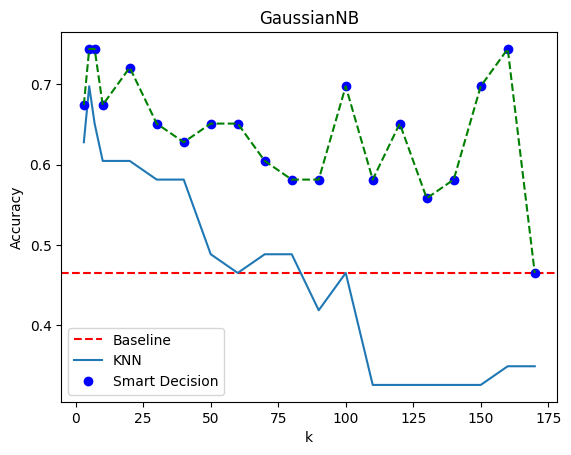

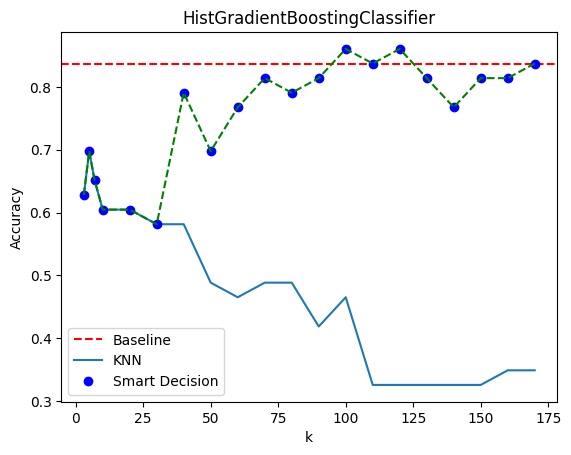

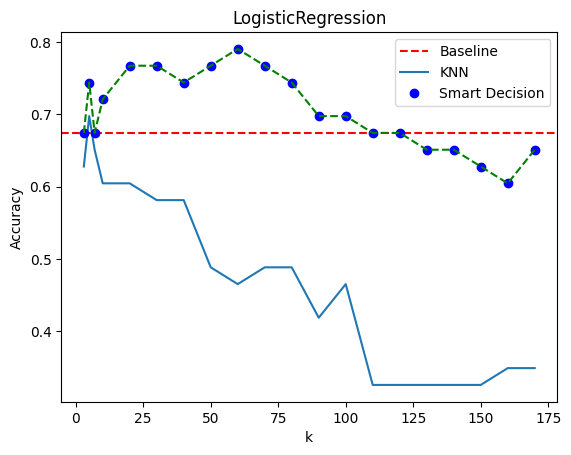

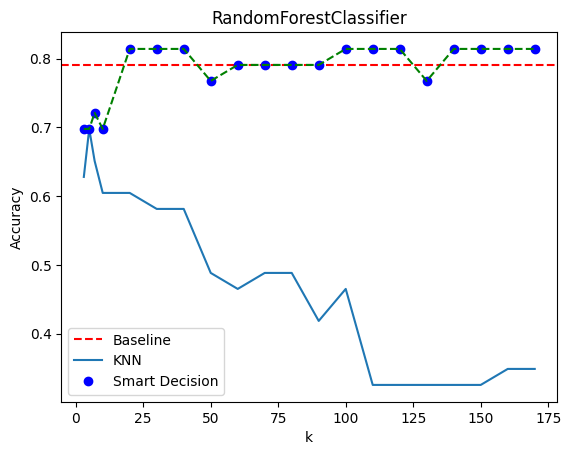

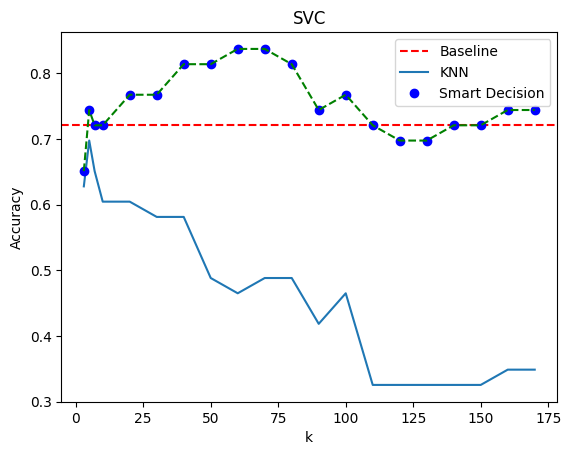

In [7]:
results_file = os.path.join('results',dataset,'results_0.json')
baseline_dict, smart_decision_dict = parse_json(results_file, type=type)
plot_scores(baseline_dict, smart_decision_dict, normalize=False, type=type)